## <center> SineRegression Task </center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
import pandas as pd
import random
import seaborn as sbs
from tqdm import tqdm_notebook as tqdm
sbs.set_style('darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

**SineRegression** 是元学习领域中的基准任务之一。给定正弦函数形式

$$y = A \sin(x + \phi)$$

按照以下步骤完成元学习算法的评估:

1. 构建元任务:学习适应不同的正弦函数对上式赋予多组不同的$(A,\phi)$值,一组不同的值代表元学习中的一个不同任务.例如:

- 任务1：y = 2sin(x + 0.5)     
- 任务2：y = 1.5sin(x + 1.2)   
- 任务3：y = 3sin(x - 0.8)
- ...

2. 选取数据点:在每个任务中,随机采一系列数量的点用作支持集(support set)和查询集(query set).
   
3. 元测试评估:在任务域上训练完以后选取未出现过的$(A,\phi)$值用作元测试任务,仍旧在任务中随机采一系列点作为支持集和查询集,评估元模型拟合正弦函数的能力.例如在新任务：y = 2.5sin(x + 2.1)上给定五个点用于拟合函数.

据此就可以写出我们采样的Task了:

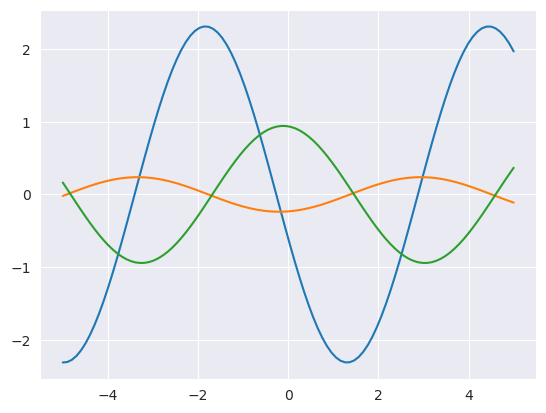

In [2]:
class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)
    
SineWaveTask().plot()
SineWaveTask().plot()
SineWaveTask().plot()
plt.show()

接下来要实现我们的模型,实现过程中有几点需要注意:

1. 元学习实操时涉及到模型参数的手动指定(比如适应后的参数)
2. 1中提到的部分in-place操作可能导致backward出错,需要手动指定leave tensor
3. 在元更新过程中可能涉及到高阶导数,不能使用默认值(PyTorch默认一阶)

In [3]:
# One can define a ModifiableModule to be a nn.Module that can be modified in-place
# This is useful for meta-learning, where we want to update the model in-place
# without having to re-instantiate the model
class ModifiableModule(nn.Module):
    def params(self):
        return [p for _, p in self.named_params()]
    
    # PyTorch will track leave tensors, so we need to override this method
    # to return the leaves of the model
    def named_leaves(self):
        return []
    
    def named_submodules(self):
        return []
    
    def named_params(self):
        subparams = []
        for name, mod in self.named_submodules():
            for subname, param in mod.named_params():
                subparams.append((name + '.' + subname, param))
        return self.named_leaves() + subparams
    
    # set_param is used to set the parameter of the model
    # it is used to update the model in-place
    # without having to re-instantiate the model
    def set_param(self, name, param):
        if '.' in name:
            n = name.split('.')
            module_name = n[0]
            rest = '.'.join(n[1:])
            for name, mod in self.named_submodules():
                if module_name == name:
                    mod.set_param(rest, param)
                    break
        else:
            setattr(self, name, param)
    
    # to cut the computational graph
    def copy(self, other, same_var=False):
        for name, param in other.named_params():
            if not same_var:
                param = V(param.data.clone(), requires_grad=True)
            self.set_param(name, param)

# GradLinear is a linear layer that can be modified in-place
# and also support higher order gradient
class GradLinear(ModifiableModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Linear(*args, **kwargs)
        self.weights = V(ignore.weight.data, requires_grad=True)
        self.bias = V(ignore.bias.data, requires_grad=True)
        
    def forward(self, x):
        return F.linear(x, self.weights, self.bias)
    
    def named_leaves(self):
        return [('weights', self.weights), ('bias', self.bias)]

class SineModel(ModifiableModule):
    def __init__(self):
        super().__init__()
        self.hidden1 = GradLinear(1, 40)
        self.hidden2 = GradLinear(40, 40)
        self.out = GradLinear(40, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)
    
    def named_submodules(self):
        return [('hidden1', self.hidden1), ('hidden2', self.hidden2), ('out', self.out)]

# A one sided example is used to test the model
# all positive or all negative
ONE_SIDED_EXAMPLE = None
while ONE_SIDED_EXAMPLE is None:
    cur = SineWaveTask()
    x, _ = cur.training_set()
    x = x.numpy()
    if np.max(x) < 0 or np.min(x) > 0:
        ONE_SIDED_EXAMPLE = cur

以上代码主要实现了支持inplace操作和追踪高阶梯度的神经网络,接下来我们插入几个用于评估和可视化的函数,后续有用:

In [4]:
# just normal training process, should be useful
# when doing transfer learning
def sine_fit1(net, wave, optim=None, get_test_loss=False, create_graph=False, force_new=False):
    net.train()
    if optim is not None:
        optim.zero_grad()
    x, y = wave.training_set(force_new=force_new)
    loss = F.mse_loss(net(V(x[:, None])), V(y).unsqueeze(1))
    loss.backward(create_graph=create_graph, retain_graph=True)
    if optim is not None:
        optim.step()
    if get_test_loss:
        net.eval()
        x, y = wave.test_set()
        loss_test = F.mse_loss(net(V(x[:, None])), V(y))
        return loss.data.cpu().numpy()[0], loss_test.data.cpu().numpy()[0]
    return loss.data.cpu().numpy()#[0]

# copy the model, used for meta-learning
def copy_sine_model(model):
    m = SineModel()
    m.copy(model)
    return m

# evaluate the model
def eval_sine_test(model, test, fits=(0, 1), lr=0.01):
    xtest, ytest = test.test_set()
    xtrain, ytrain = test.training_set()

    model = copy_sine_model(model)
    # Not sure if this should be Adam or SGD.
    optim = torch.optim.SGD(model.params(), lr)
        
    def get_loss(res):
        return F.mse_loss(res, V(ytest[:, None])).cpu().data.numpy()#[0]
    
    fit_res = []
    if 0 in fits:
        results = model(V(xtest[:, None]))
        fit_res.append((0, results, get_loss(results)))
    for i in range(np.max(fits)):
        sine_fit1(model, test, optim)
        if i + 1 in fits:
            results = model(V(xtest[:, None]))
            fit_res.append(
                (
                    i + 1, 
                    results,
                    get_loss(results)
                )
            )

    return fit_res

# doing the evaluation and plot the result
def plot_sine_test(model, test, fits=(0, 1), lr=0.01):
    xtest, ytest = test.test_set()
    xtrain, ytrain = test.training_set()

    fit_res = eval_sine_test(model, test, fits, lr)
    
    train, = plt.plot(xtrain.numpy(), ytrain.numpy(), '^')
    ground_truth, = plt.plot(xtest.numpy(), ytest.numpy())
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        cur, = plt.plot(xtest.numpy(), res.cpu().data.numpy()[:, 0], '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.show()

# visualize more concrete results
def plot_sine_learning(models, sine_test, fits=(0, 1), lr=0.01, marker='s', linestyle='--'):
    data = {'model': [], 'fits': [], 'loss': [], 'set': []}
    for name, models in models:
        if not isinstance(models, list):
            models = [models]
        for n_model, model in enumerate(models):
            for n_test, test in enumerate(sine_test):
                n_test = n_model * len(sine_test) + n_test
                fit_res = eval_sine_test(model, test, fits, lr)
                for n, _, loss in fit_res:
                    data['model'].append(name)
                    data['fits'].append(n)
                    data['loss'].append(loss)
                    data['set'].append(n_test)
    data['loss'] = list(np.array(data['loss']))
    sbs.lineplot(data=pd.DataFrame(data), x='fits', 
             y='loss', hue='model', 
             linestyle=linestyle,
             markers=marker,estimator=np.mean)
    return data

以下代码用于构建元任务、开展元训练并执行元测试,具体而言,在元训练和元测试阶段,操作流程如下:
- 首先创建一个初始权重的副本用于赋值,同时`.copy()`方法可以切断复制后用于内循环的权重和元模型权重的计算图
- 在副本上对随机任务运行一次梯度下降迭代
- 将测试集上的损失通过梯度下降迭代反向传播回初始权重，这样我们就可以在使初始权重更容易更新的方向上更新初始权重

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

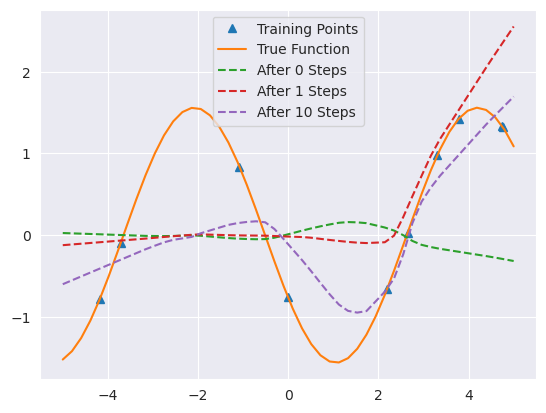

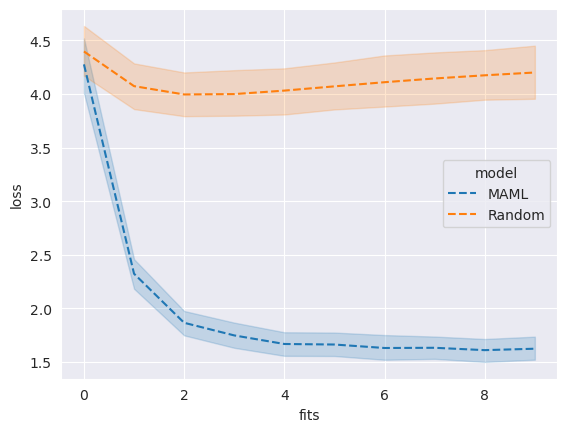

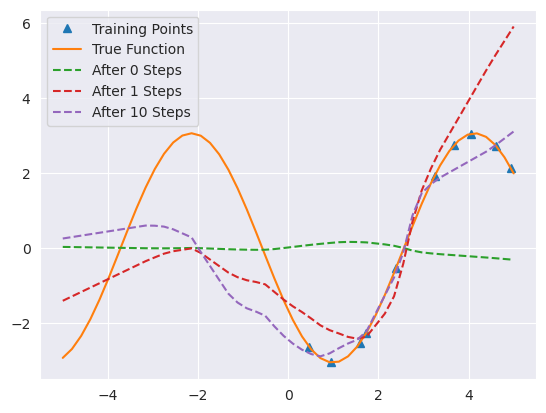

In [5]:
# ===============================
# 1. Build Meta-Learning Task
# ===============================

TRAIN_SIZE = 10000
TEST_SIZE = 1000

SINE_TRAIN = [SineWaveTask() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask() for _ in range(TEST_SIZE)]

# ===============================
# 2. Perform Meta-Training
# ===============================

def maml_sine(model, epochs, lr_inner=0.01, batch_size=1, first_order=False):
    optimizer = torch.optim.Adam(model.params())
    
    for _ in tqdm(range(epochs)):
        # Note: the paper doesn't specify the meta-batch size for this task,
        # so I just use 1 for now.
        for i, t in enumerate(random.sample(SINE_TRAIN, len(SINE_TRAIN))):
            new_model = SineModel()
            new_model.copy(model, same_var=True)
            loss = sine_fit1(new_model, t, create_graph=not first_order)
            for name, param in new_model.named_params():
                grad = param.grad
                if first_order:
                    grad = V(grad.detach().data)
                new_model.set_param(name, param - lr_inner * grad)
                        
            sine_fit1(new_model, t, force_new=True)

            if (i + 1) % batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()
                    
SINE_MAML = [SineModel() for _ in range(5)]

for m in SINE_MAML:
    maml_sine(m, 4)


# ===============================
# 3. Perform Meta-Testing and Visualize Results
# ===============================

plot_sine_test(SINE_MAML[0], SINE_TEST[0], fits=[0, 1, 10], lr=0.01)
plt.show()

plot_sine_learning(
    [('MAML', SINE_MAML[0]), ('Random', SineModel())],
    SINE_TEST,
    list(range(10)),
)
plt.show()

plot_sine_test(SINE_MAML[0], ONE_SIDED_EXAMPLE, fits=[0, 1, 10], lr=0.01)
plt.show()

以上是元学习在**SineRegression**任务上的表现,在`outline.md`当中我们同时还提到了迁移学习,似乎两者都致力于学习到一个蕴含丰富知识的初始化,不过可以预期的是,`Transfer Learning`的方法完全不适用于**SineRegression**任务,我们可以简单的验证一下:

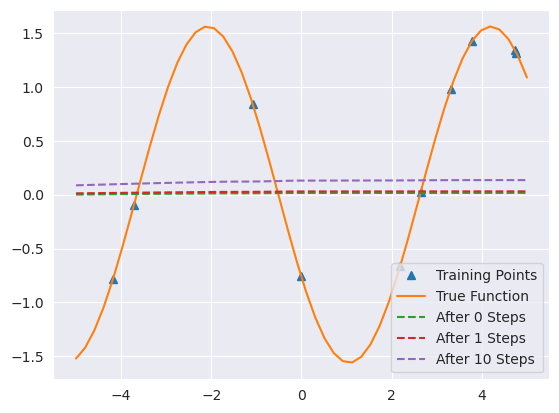

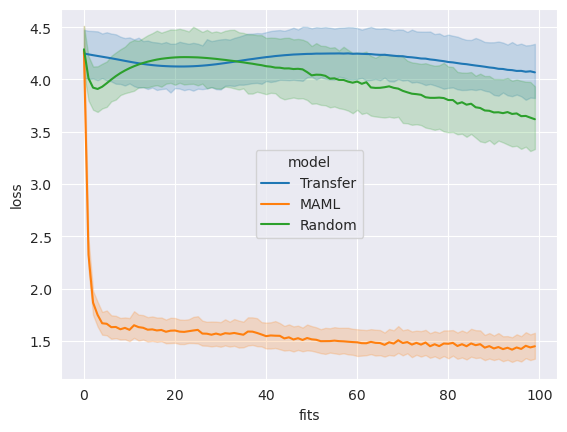

In [6]:
# ===============================
# 1. Build Transfer Learning Model
# ===============================

SINE_TRANSFER = SineModel()
            
# ===============================
# 2. Perform Transfer Learning
# ===============================

def fit_transfer(epochs=1):
    optim = torch.optim.Adam(SINE_TRANSFER.params())

    for _ in range(epochs):
        for t in random.sample(SINE_TRAIN, len(SINE_TRAIN)):
            sine_fit1(SINE_TRANSFER, t, optim)
            
fit_transfer()

# ===============================
# 3. Perform Transfer Learning and Visualize Results
# ===============================

plot_sine_test(SINE_TRANSFER, SINE_TEST[0], fits=[0, 1, 10], lr=0.02)

data = plot_sine_learning(
    [('Transfer', SINE_TRANSFER), ('MAML', SINE_MAML[0]), ('Random', SineModel())],
    SINE_TEST,
    list(range(100)),
    marker='',
    linestyle='-'
)
plt.show()

正如`outline.md`中所指出的那样,迁移学习更倾向于学习`平均化`的知识,其实这是显而易见的:

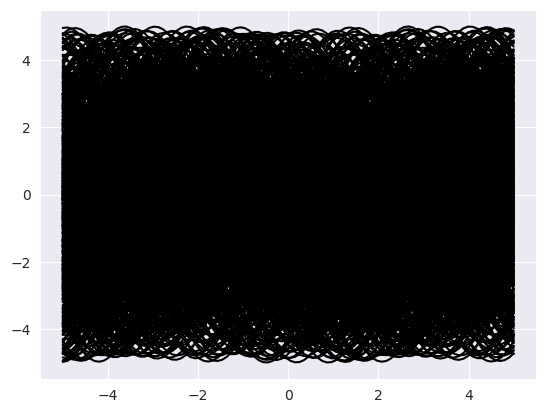

In [7]:
for _ in range(1000):
    SineWaveTask().plot(color='black')

由于跨多个任务的每个$x$都有多个可能的值，如果我们训练一个单一的神经网络来同时处理多个任务，它的最佳策略就是简单地为每个$x$返回所有任务中$y$值的平均值。这会是什么样子呢？

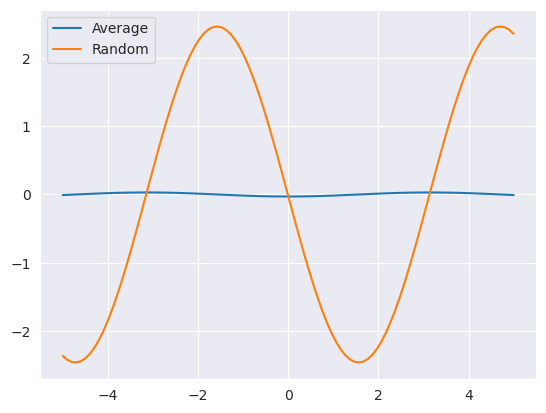

In [8]:
all_x, all_y = [], []

for _ in range(10000):
    curx, cury = SineWaveTask().test_set(size=100)
    all_x.append(curx.numpy())
    all_y.append(cury.numpy())

avg, = plt.plot(all_x[0], np.mean(all_y, axis=0))
rand, = SineWaveTask().plot()
plt.legend([avg, rand], ['Average', 'Random'])
plt.show()

平均值基本上是0，这意味着在大量任务上训练的神经网络会在所有地方都简单地返回0！所以对于这个问题，MAML比迁移学习或随机初始化要好得多。

然而，在之前的视线中我们使用了二阶导数,这会减慢运行的速度（根据论文，大约慢33%，这与我们这里将要看到的情况相符）。

在`outline.md`中的推导部分我们已经看见一阶导数近似的方法,很巧的是,我们只要让`first_order=True`就可以使得二者数学形式匹配了.

那么这个一阶近似的效果如何呢？事实证明，虽然略逊于MAML，但效果仍然不错！

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

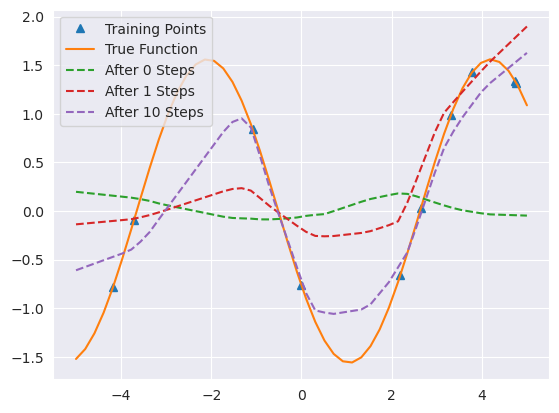

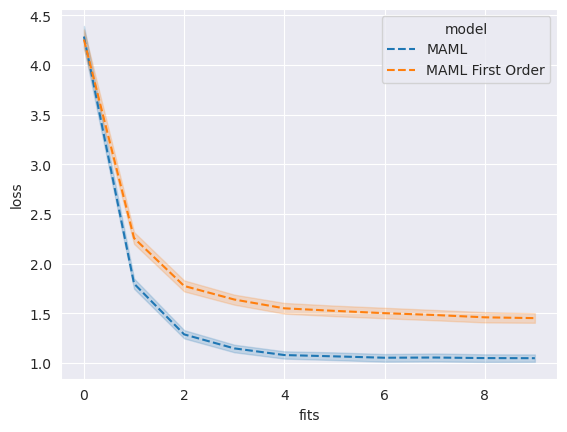

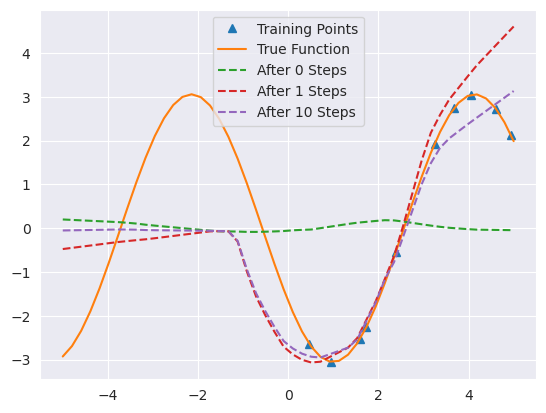

In [10]:
SINE_MAML_FIRST_ORDER = [SineModel() for _ in range(5)]

for m in SINE_MAML_FIRST_ORDER:
    maml_sine(m, 4, first_order=True)

plot_sine_test(SINE_MAML_FIRST_ORDER[0], SINE_TEST[0], fits=[0, 1, 10], lr=0.01)
plt.show()

plot_sine_learning(
    [('MAML', SINE_MAML), ('MAML First Order', SINE_MAML_FIRST_ORDER)],
    SINE_TEST,
    list(range(10)),
)
plt.show()

plot_sine_test(SINE_MAML_FIRST_ORDER[0], ONE_SIDED_EXAMPLE, fits=[0, 1, 10], lr=0.01)
plt.show()